This notebook provides a minimal working example of the image-to-painting translation (progressive rendering) in the preprint paper "Stylized Neural Painting, arXiv:2011.08114."

[Project Page](https://jiupinjia.github.io/neuralpainter/) | [GitHub](https://github.com/jiupinjia/stylized-neural-painting) | [Preprint](https://arxiv.org/abs/2011.08114)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">   The project </a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [1]:
# Clone the repository
# !git clone https://github.com/jiupinjia/stylized-neural-painting

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 198 (delta 29), reused 26 (delta 10), pack-reused 143
Receiving objects: 100% (198/198), 3.63 MiB | 6.98 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [1]:
cd stylized-neural-painting

/Users/chendeen/Documents/programming/stylized-neural-painting/stylized-neural-painting


In [14]:
import argparse

import torch
# torch.cuda.current_device()
import torch.optim as optim

from painter import *
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# settings
parser = argparse.ArgumentParser(description='STYLIZED NEURAL PAINTING')
args = parser.parse_args(args=[])
args.img_path = '../6.jpeg' # path to input photo
# args.img_path = './test_images/iceland.jpg' # path to input photo

args.renderer = 'oilpaintbrush' # [watercolor, markerpen, oilpaintbrush, rectangle]
args.canvas_color = 'white' # [black, white]
# args.canvas_color = 'black' # [black, white]

# 这里Canvas_size为像素数。
args.canvas_size = 1000 # size of the canvas for stroke rendering'
# args.canvas_size = 550 # size of the canvas for stroke rendering'
# args.canvas_size = 512 # size of the canvas for stroke rendering'

args.keep_aspect_ratio = False # whether to keep input aspect ratio when saving outputs

# args.max_m_strokes = 1500 # max number of strokes
args.max_m_strokes = 1000 # max number of strokes
# args.max_m_strokes = 500 # max number of strokes
# args.max_divide = 10 # divide an image up-to max_divide x max_divide patches
args.max_divide = 5 # divide an image up-to max_divide x max_divide patches

args.beta_L1 = 1.0 # weight for L1 loss
args.with_ot_loss = False # set True for imporving the convergence by using optimal transportation loss, but will slow-down the speed
args.beta_ot = 0.1 # weight for optimal transportation loss
args.net_G = 'zou-fusion-net' # renderer architecture
args.renderer_checkpoint_dir = './checkpoints_G_oilpaintbrush' # dir to load the pretrained neu-renderer
args.lr = 0.005 # learning rate for stroke searching
# args.output_dir = '/content/stylized-neural-painting/output' # dir to save painting results
args.output_dir = './output' # dir to save painting results

args.disable_preview = True # disable cv2.imshow, for running remotely without x-display

Download pretrained neural renderer.

In [16]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [18]:
# download and unzip...
file_id = '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG'
destination = './checkpoints_G_oilpaintbrush.zip'
download_file_from_google_drive(file_id, destination)

In [6]:
!unzip checkpoints_G_oilpaintbrush.zip

Archive:  checkpoints_G_oilpaintbrush.zip
   creating: checkpoints_G_oilpaintbrush/
  inflating: checkpoints_G_oilpaintbrush/last_ckpt.pt  


In [13]:
# # download and unzip...
# file_id = '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG'
# destination = './checkpoints_G_oilpaintbrush_light.zip'
# download_file_from_google_drive(file_id, destination)

In [14]:
# !unzip checkpoints_G_oilpaintbrush_light.zip


Archive:  checkpoints_G_oilpaintbrush_light.zip
replace checkpoints_G_oilpaintbrush/last_ckpt.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Define the optimization loop the painter

In [19]:
# 关键是找到参数的物理意义。
def optimize_x(pt):

    pt._load_checkpoint() # 加载网络权重
    pt.net_G.eval() # 设置成评估模式
    # 训练好的网络参数是用于生成笔触的。

    print('begin drawing...')

    # pt.rderr.d是12
    PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

    if pt.rderr.canvas_color == 'white':
        CANVAS_tmp = torch.ones([1, 3, 128, 128]).to(device)
    else:
        CANVAS_tmp = torch.zeros([1, 3, 128, 128]).to(device)

    # 每个块
    for pt.m_grid in range(1, pt.max_divide + 1):

        pt.img_batch = utils.img2patches(pt.img_, pt.m_grid, pt.net_G.out_size).to(device)
        pt.G_final_pred_canvas = CANVAS_tmp

        pt.initialize_params()
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True
        utils.set_requires_grad(pt.net_G, False)

        # pt.optimizer_x在此定义。优化 pt.x_ctt, pt.x_color, pt.x_alpha
        pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

        pt.step_id = 0
        for pt.anchor_id in range(0, pt.m_strokes_per_block):
            pt.stroke_sampler(pt.anchor_id)
            iters_per_stroke = int(500 / pt.m_strokes_per_block)
            for i in range(iters_per_stroke):
                pt.G_pred_canvas = CANVAS_tmp

                # update x
                pt.optimizer_x.zero_grad()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1) # 夹紧到区间
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt._forward_pass()
                pt._drawing_step_states()
                pt._backward_x()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt.optimizer_x.step()
                pt.step_id += 1

        v = pt._normalize_strokes(pt.x)
        v = pt._shuffle_strokes_and_reshape(v)
        PARAMS = np.concatenate([PARAMS, v], axis=1)
        CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
        CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

    # 同一个PARAMS传入下面这两个函数。
    # 循环完毕，得到最终参数 PARAMS。
    pt._save_stroke_params(PARAMS)
    # 最后渲染出的图像，PARAMS 参数的使用。
    final_rendered_image = pt._render(PARAMS, save_jpgs=False, save_video=True)

    return final_rendered_image

In [22]:
# 最上方输入的参数，包括输入图像
pt = ProgressivePainter(args=args)

initialize network with normal


Now you can process your image

In [9]:

# 因此 optimize_x 函数针对每一个图像都要运行一次，返回最后渲染出的图像
final_rendered_image = optimize_x(pt)

initialize network with normal
loading renderer from pre-trained checkpoint...
begin drawing...
iteration step 0, G_loss: 0.00000, step_acc: 3.59066, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 1, G_loss: 0.60322, step_acc: 3.65412, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 2, G_loss: 0.59617, step_acc: 3.70181, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 3, G_loss: 0.59076, step_acc: 3.77484, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 4, G_loss: 0.58287, step_acc: 3.83093, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 5, G_loss: 0.57678, step_acc: 3.87047, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 6, G_loss: 0.57212, step_acc: 3.93076, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 7, G_loss: 0.56567, step_acc: 3.99466, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 8, G_loss: 0.55884, step_acc: 4.04954, grid_scale: 1 / 10, strokes: 1 / 3
iteration step 9, G_loss: 0.55208, step_acc: 4.09435, grid_scale: 1 / 10, strokes: 1 / 3
iteration step

Check out your animated results at args.output_dir. Before you download that folder, let's first have a look at what the generated painting looks like.

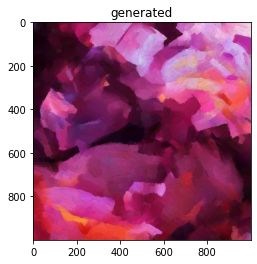

In [10]:
# final_rendered_image 是最后渲染出的图像，是针对输入的图像的
plt.imshow(final_rendered_image), plt.title('generated')
plt.show()